### Single Run with Priority

This notebook is developed based on single run for multiple containers. One dredging vessel along with one seagoing vessel serve the same berth area.
The aim of this notebook is to find out how the single run and vessels log change when
* case 1: the dredging vessel is prior
* case 2: the seagoing vessel is prior

In [569]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime, time
import simpy
import openclsim
import opentnsim

import pandas as pd

import matplotlib.pyplot as plt
import folium

In [570]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

Number of edges is 4


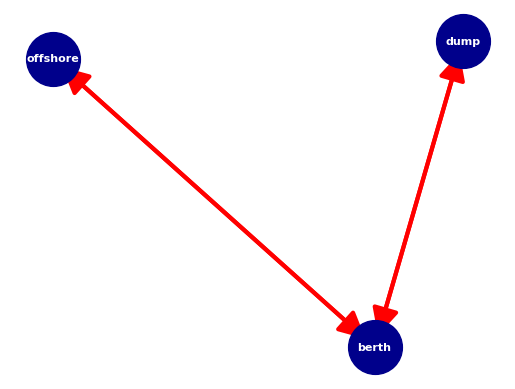

In [571]:
# we start with creating a graph 
graph = nx.DiGraph()

# make your preferred Site class out of available mix-ins which is a combination of mixins from OpenCLSim and OpenTNSim.
Location = type('Site',
            (openclsim.core.Identifiable,
             openclsim.core.Log,
             openclsim.core.Locatable,
             openclsim.core.HasContainer,
             openclsim.core.HasResource,), {})

# three locations (offshore, berth, and dump) are defined to allow the vessels pass the nodes back and forth.
# based on the mixins, more attributes are defined for each location.
locations = []

location_offshore = shapely.geometry.Point(3.637610458072877, 52.10701582514347)
data_offshore = {"env": my_env,
                 "name": "offshore",
                 "geometry": location_offshore,
                 "capacity": 100,
                 "level": 100,
                }
locations.append(Location(**data_offshore))
offshore = Location(**data_offshore)

location_berth = shapely.geometry.Point(4.062705498083785,51.95909715255291)
data_berth = {"env": my_env,
              "name": "berth",
              "geometry": location_berth,
              "capacity": 100,
              "level": 100,
             }
locations.append(Location(**data_berth))
berth = Location(**data_berth)

location_dump = shapely.geometry.Point(4.1795229742823,52.11590591837503)
data_dump = {"env": my_env,
             "name": "dump",
             "geometry": location_dump,
             "capacity": 100,
             "level": 0
            }
locations.append(Location(**data_dump))
dump = Location(**data_dump)   
        
# a graph is initiated based on the name and gemometry of locations.
# other attributes such as store_capacity and initials are not being used for drawing the graph.
for location in locations:
    graph.add_node(location.name,
                geometry = location.geometry)
     
# add edges
path = [[locations[i], locations[i+1]] for i in range(len(locations)-1)]

for index, edge in enumerate(path):
    graph.add_edge(edge[0].name, edge[1].name, weight = 1)
    
# toggle to undirected and back to directed to make sure all edges are two way traffic
graph = graph.to_undirected() 
graph = graph.to_directed()

# create a positions dict for the purpose of plotting
positions = {}
for location in graph.nodes:
    positions[location] = (graph.nodes[location]['geometry'].x, graph.nodes[location]['geometry'].y)
    
# collect node labels.
labels = {}
for location in graph.nodes:
    labels[location] = location
print('Number of edges is {}'.format(len(graph.edges)))

# draw edges, nodes and labels.
nx.draw_networkx_edges(graph,  pos=positions, width=3, edge_color="red", alpha=1, arrowsize=40)
nx.draw_networkx_nodes(graph,  pos=positions, node_color="darkblue", node_size=1500)
nx.draw_networkx_labels(graph, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="white")

plt.axis("off")
plt.show()

In [572]:
# add a graph to the environment
my_env.graph = graph

In [573]:
m = folium.Map(location=[52.66, 4.43], zoom_start=8)

folium.Marker(
    [location_dump.y, location_dump.x ], 
    popup="<b>Dump</b>", 
    tooltip="Dump"
).add_to(m)
folium.Marker(
    [location_offshore.y, location_offshore.x ], 
    popup="<b>Offshore</b>", 
    tooltip="Offshore"
).add_to(m)
folium.Marker(
    [location_berth.y, location_berth.x ], 
    popup="<b>Berth</b>", 
    tooltip="Berth"
).add_to(m)

m

In [574]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource  object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        opentnsim.core.Movable,
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Processor,
        openclsim.core.HasResource,
        openclsim.core.LoadingFunction,
        openclsim.core.UnloadingFunction,
#         # capture extra metadata to make sure we don't have leftover arguments
        opentnsim.core.ExtraMetadata,
        openclsim.core.Priority
    ),
    {},
)

In [575]:
# prepare input data for vessel_01
data_vessel01 = {
    "env": my_env,                  # assigning the simpy environment
    "name": "dredging vessel",      # vessel 01 is the dredging vessel in the simulation
    "geometry": location_berth, 
    "loading_rate": 1,
    "unloading_rate": 5,
    "capacity": 10,
    #"priority": 1,
    "v": 10,
    "route": [berth, dump]
}
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)
# assert not vessel01.metadata

In [576]:
# initialise registry
registry = {}

In [577]:
# create a 'while activity' that contains a pre-packed set of 'sub_processes'
single_run, while_activity  = openclsim.model.single_run_process(
    name="single_run",
    registry={},
    env=my_env,
    origin=berth,
    destination=dump,
    mover=vessel01,
    loader=vessel01,
    unloader=vessel01,
)
# activity = openclsim.model.MoveActivity(
#     env=my_env,
#     name="Move activity of dredging vessel",
#     registry=registry,
#     mover=vessel01,
#     destination=dump,
# )

In [578]:
openclsim.model.register_processes([while_activity])

ValueError: Due to recursion in the events of the activities, not all the activities can be registered.

In [ ]:
my_env.run()

mover dredging vessel destination dump


KeyError: <__main__.Site object at 0x000002375EA9ABE0>

In [ ]:
display(openclsim.plot.get_log_dataframe(activity))

,Activity,Timestamp,ActivityState


In [ ]:
# define a path into and out of the habour
path1 = nx.dijkstra_path(my_env.graph, 'offshore', 'berth')
path2 = nx.dijkstra_path(my_env.graph, 'berth', 'offshore')
path = path1+path2[1:]
display(path)
    
# create a dict with all important settings
data_vessel02 = {"env": my_env,                     # needed for simpy simulation
               "name": 'seagoing vessel',           # required by Identifiable
               "geometry": location_offshore        # required by Locatable
               "route": path,                       # required by Routeable
               "priority": 2,                       # the seagoing vessel has the second priority to serve the berth location
               "v": 1,}                             # required by Movable

# instantiate vessel_02 
vessel02 = TransportProcessingResource(**data_vessel02)
assert not vessel02.metadata

SyntaxError: invalid syntax (1783551121.py, line 11)

In [ ]:
# specify the process that needs to be executed
my_env.process(vessel02.move())

<Process(move) object at 0x2375da25340>

In [ ]:
# start the simulation
my_env.run()

mover dredging vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geometry POI

In [ ]:
display(openclsim.plot.get_log_dataframe(vessel01, [*single_run, while_activity]))

,Activity,Timestamp,ActivityState,geometry,container level
0,single_run sailing empty,1970-01-01 00:00:00.000000,START,POINT (4.062705498083785 51.95909715255291),0.0
1,single_run sailing empty,1970-01-01 00:00:00.000000,STOP,POINT (4.062705498083785 51.95909715255291),0.0
2,single_run loading,1970-01-01 00:00:00.000000,START,POINT (4.062705498083785 51.95909715255291),0.0
3,single_run loading,1970-01-01 00:00:10.000000,STOP,POINT (4.062705498083785 51.95909715255291),10.0
4,single_run sailing filled,1970-01-01 00:00:10.000000,START,POINT (4.062705498083785 51.95909715255291),10.0
...,...,...,...,...,...
75,single_run loading,1970-01-01 08:49:59.864804,STOP,POINT (4.062705498083785 51.95909715255291),10.0
76,single_run sailing filled,1970-01-01 08:49:59.864804,START,POINT (4.062705498083785 51.95909715255291),10.0
77,single_run sailing filled,1970-01-01 09:16:39.958986,STOP,POINT (4.1795229742823 52.11590591837503),10.0
78,single_run unloading,1970-01-01 09:16:39.958986,START,POINT (4.1795229742823 52.11590591837503),10.0


In [ ]:
openclsim.plot.get_gantt_chart([while_activity, vessel01, *single_run])

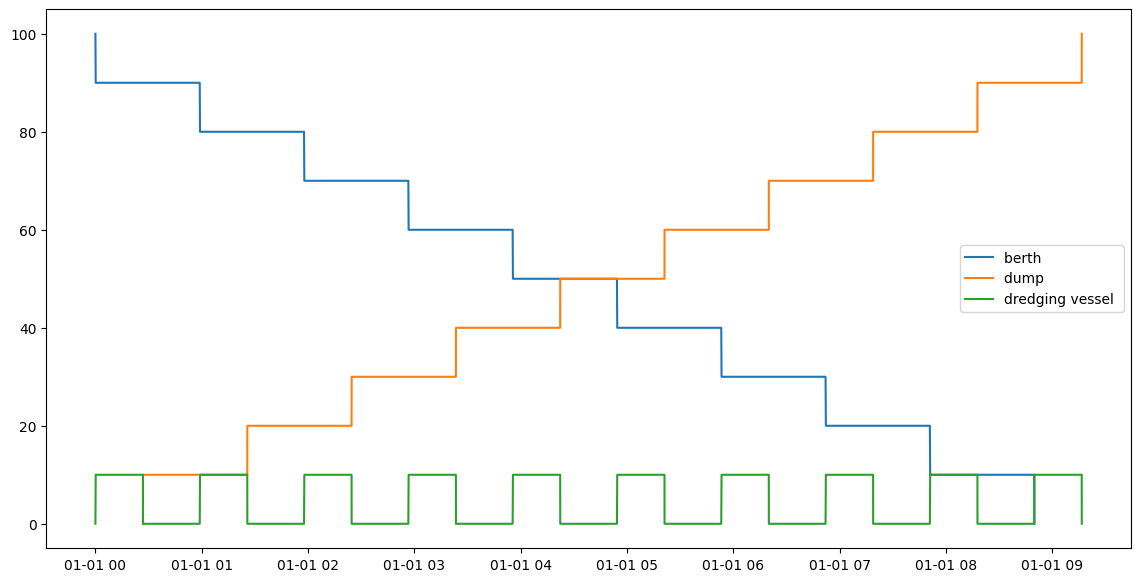

In [ ]:
fig = openclsim.plot.get_step_chart([berth, dump, vessel01])

In [ ]:
vessel02.log

{'Message': ['Sailing from node offshore to node berth start',
  'Sailing from node offshore to node berth stop',
  'Sailing from node berth to node offshore start',
  'Sailing from node berth to node offshore stop'],
 'Timestamp': [Timestamp('1970-01-01 01:00:00'),
  Timestamp('1970-01-01 10:18:15.594056'),
  Timestamp('1970-01-01 10:18:15.594056'),
  Timestamp('1970-01-01 19:36:31.188113')],
 'Value': [0, 0, 0, 0],
 'Geometry': [<POINT (3.638 52.107)>,
  <POINT (4.063 51.959)>,
  <POINT (4.063 51.959)>,
  <POINT (3.638 52.107)>]}

In [ ]:
# note the slightly different log handling than for the openclsim elemnents
df = pd.DataFrame.from_dict(vessel02.log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node offshore to node berth start,1970-01-01 01:00:00.000000,0,POINT (3.637610458072877 52.10701582514347)
1,Sailing from node offshore to node berth stop,1970-01-01 10:18:15.594056,0,POINT (4.062705498083785 51.95909715255291)
2,Sailing from node berth to node offshore start,1970-01-01 10:18:15.594056,0,POINT (4.062705498083785 51.95909715255291)
3,Sailing from node berth to node offshore stop,1970-01-01 19:36:31.188113,0,POINT (3.637610458072877 52.10701582514347)
